# notebook for create init and true test model

In [6]:
import numpy as np
import math

# grid
R_earth = 6371.0

rr1=6361 
rr2=6381
tt1=(38.0-0.3)/180*math.pi
tt2=(42.0+0.3)/180*math.pi
pp1=(23.0-0.3)/180*math.pi
pp2=(27.0+0.3)/180*math.pi

n_rtp = [10,50,50]
dr = (rr2-rr1)/(n_rtp[0]-1)
dt = (tt2-tt1)/(n_rtp[1]-1)
dp = (pp2-pp1)/(n_rtp[2]-1)
rr = np.array([rr1 + x*dr for x in range(n_rtp[0])])
tt = np.array([tt1 + x*dt for x in range(n_rtp[1])])
pp = np.array([pp1 + x*dp for x in range(n_rtp[2])])

# initial model
gamma = 0.0
s0 = 1.0/6.0
slow_p=0.06
ani_p=0.04

eta_init = np.zeros(n_rtp)
xi_init  = np.zeros(n_rtp)
zeta_init = np.zeros(n_rtp)
fun_init = np.zeros(n_rtp)
vel_init = np.zeros(n_rtp)

# true model
eta_true = np.zeros(n_rtp)
xi_true  = np.zeros(n_rtp)
zeta_true = np.zeros(n_rtp)
fun_true = np.zeros(n_rtp)
vel_true = np.zeros(n_rtp)

c=0
for ir in range(n_rtp[0]):
    for it in range(n_rtp[1]):
        for ip in range(n_rtp[2]):
            # already initialized above
            #eta_init[ir,it,ip] = 0.0
            #xi_init[ir,it,ip]  = 0.0
            zeta_init[ir,it,ip] = gamma*math.sqrt(eta_init[ir,it,ip]**2 + xi_init[ir,it,ip]**2)
            fun_init[ir,it,ip] = s0
            vel_init[ir,it,ip] = 1.0/s0

            # true model
            if (tt[it] >= 38.0/180.0*math.pi and tt[it] <= 42.0/180.0*math.pi \
            and pp[ip] >= 23.0/180.0*math.pi and pp[ip] <= 27.0/180.0*math.pi):
                c+=1
                sigma = math.sin(2.0*math.pi*(tt[it]-38.0/180.0*math.pi)/(4.0/180.0*math.pi))*math.sin(2.0*math.pi*(pp[ip]-23.0/180.0*math.pi)/(4.0/180.0*math.pi))
            else:
                sigma = 0.0

            if sigma < 0:
                psi = 60.0/180.0*math.pi
            elif sigma > 0:
                psi = 120.0/180.0*math.pi
            else:
                psi = 0.0

            eta_true[ir,it,ip] = ani_p*abs(sigma)*math.sin(2.0*psi)
            xi_true[ir,it,ip]  = ani_p*abs(sigma)*math.cos(2.0*psi)
            zeta_true[ir,it,ip] = gamma*math.sqrt(eta_true[ir,it,ip]**2 + xi_true[ir,it,ip]**2)
            fun_true[ir,it,ip] = s0/(1.0+sigma*slow_p)
            vel_true[ir,it,ip] = 1.0/fun_true[ir,it,ip]    


#r_earth = 6378.1370
print("depminmax {} {}".format(R_earth-rr1,R_earth-rr2))
print(c)


depminmax 10.0 -10.0
17640


In [7]:
# write out in hdf5 format
import h5py

fout_init = h5py.File('test_model_init.h5', 'w')
fout_true = h5py.File('test_model_true.h5', 'w')

# write out the arrays eta_init, xi_init, zeta_init, fun_init, a_init, b_init, c_init, f_init
fout_init.create_dataset('eta', data=eta_init)
fout_init.create_dataset('xi', data=xi_init)
fout_init.create_dataset('zeta', data=zeta_init)
fout_init.create_dataset('vel', data=vel_init)

# writeout the arrays eta_true, xi_true, zeta_true, fun_true, a_true, b_true, c_true, f_true
fout_true.create_dataset('eta', data=eta_true)
fout_true.create_dataset('xi', data=xi_true)
fout_true.create_dataset('zeta', data=zeta_true)
fout_true.create_dataset('vel', data=vel_true)

fout_init.close()
fout_true.close()


# prepare src station file

The following code creates a src_rec_file for the inversion, which describes the source and receiver positions and arrival times.
Format is as follows:

```
        26 1992  1  1  2 43  56.900    1.8000     98.9000 137.00  2.80    8    305644 <- src   　: id_src year month day hour min sec lat lon dep_km mag num_recs id_event
     26      1      PCBI       1.8900     98.9253   1000.0000  P   10.40  18.000      <- arrival : id_src id_rec name_rec lat lon elevation_m phase epicentral_distance_km arrival_time_sec
     26      2      MRPI       1.6125     99.3172   1100.0000  P   50.84  19.400
     26      3      HUTI       2.3153     98.9711   1600.0000  P   57.84  19.200
     ....

```

In [8]:
import random
random.seed(1145141919810)

# dummys
year_dummy = 1998
month_dummy = 1
day_dummy = 1
hour_dummy = 0
minute_dummy = 0
second_dummy = 0
mag_dummy = 3.0
id_dummy = 1000
st_name_dummy = 'AAAA'
phase_dummy = 'P'
dist_dummy = 100.0
arriv_t_dummy = 0.0

tt1deg = tt1 * 180.0/math.pi
tt2deg = tt2 * 180.0/math.pi
pp1deg = pp1 * 180.0/math.pi
pp2deg = pp2 * 180.0/math.pi


n_srcs = [5,10,10]
n_src = n_srcs[0]*n_srcs[1]*n_srcs[2]
n_rec = [30 for x in range(n_src)]


lines = []

nij_src = math.sqrt(n_src)
nij_rec = math.sqrt(n_rec[0])

pos_src=[]
pos_rec=[]


# create receiver coordinates
elev_recs=[]
lon_recs=[]
lat_recs=[]
rec_names=[]
for i in range(n_rec[0]):
    #elev_recs.append(random.uniform(-100.0,-100.0)) # elevation in m
    #elev_recs.append(0) # elevation in m
    #lon_recs .append(random.uniform(pp1deg*1.1,pp2deg*0.9))
    #lat_recs .append(random.uniform(tt1deg*1.1,tt2deg*0.9))
    rec_names.append(i)
    # regularly
    elev_recs.append(0.0)
    tmp_ilon = i%nij_rec
    tmp_ilat = int(i/nij_rec)
    lon_recs.append(pp1deg + tmp_ilon*(pp2deg-pp1deg)/nij_rec)
    lat_recs.append(tt1deg + tmp_ilat*(tt2deg-tt1deg)/nij_rec)



# create source coordinates
for ir in range(n_srcs[0]):
    for it in range(n_srcs[1]):
        for ip in range(n_srcs[2]):
            i_src = ir*n_srcs[1]*n_srcs[2] + it*n_srcs[2] + ip
            # define one point in the domain (rr1 bottom, rr2 top)
            # random
            #dep = random.uniform((R_earth-rr1)*0.5,(R_earth-rr1)*0.98)
            #lon = random.uniform(pp1deg,pp2deg)
            #lat = random.uniform(tt1deg,tt2deg)

            # regular
            dep = (R_earth-rr1)/n_srcs[0]*ir
            lon = pp1deg + ip*(pp2deg-pp1deg)/n_srcs[2]
            lat = tt1deg + it*(tt2deg-tt1deg)/n_srcs[1]

            # put independent name for each source
            id_dummy = "src_"+str(i_src)
 
            src = [i_src, year_dummy, month_dummy, day_dummy, hour_dummy, minute_dummy, second_dummy, lat, lon, dep, mag_dummy, n_rec[i_src], id_dummy]
            lines.append(src)

            pos_src.append([lon,lat,dep])


            # create dummy station
            for i_rec in range(n_rec[i_src]):
                elev_rec = elev_recs[i_rec]
                lon_rec  = lon_recs[i_rec]
                lat_rec  = lat_recs[i_rec]
                st_name_dummy = "rec_"+str(rec_names[i_rec])

                rec = [i_src, i_rec, st_name_dummy, lat_rec, lon_rec, elev_rec, phase_dummy, dist_dummy, arriv_t_dummy]
                lines.append(rec)
        
                pos_rec.append([lon_rec,lat_rec,elev_rec])


# write out ev_arrivals file
fname = 'src_rec_test.dat'

with open(fname, 'w') as f:
    for line in lines:
        for elem in line:
            f.write('{} '.format(elem))
        f.write('\n')
        

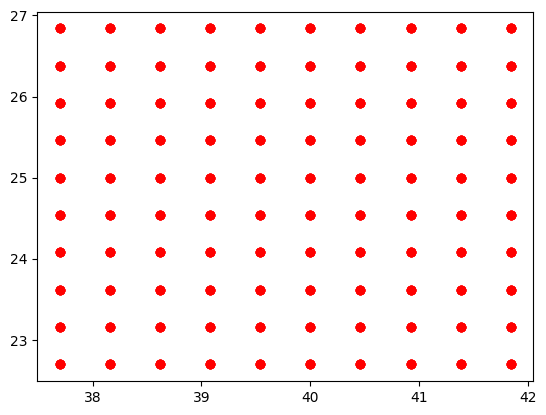

In [9]:
# draw src and rec positions
import matplotlib.pyplot as plt

for i_src in range(n_src):
    plt.scatter(pos_src[i_src][1],pos_src[i_src][0],c='r',marker='o')

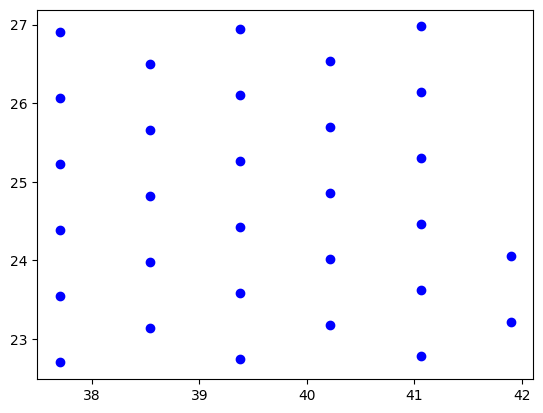

In [10]:
# plot receivers
for i_rec in range(n_rec[0]):
    plt.scatter(pos_rec[i_rec][1],pos_rec[i_rec][0],c='b',marker='o')